In [0]:
import pandas as pd
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [0]:
%matplotlib inline

## import and investigate data set

---




In [3]:
data = pd.read_csv('dataProject.csv')
data.head()

,id,state,stop_date,stop_time,stop_datetime,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,driver_age_raw,driver_age,driver_race_raw,driver_race,violation_raw,violation,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id
0,VT-2010-00001,VT,7/1/10,0:10,2010-07-01T00:10:00,East Montpelier,Washington County,50023.0,COUNTY RD,MIDDLESEX VSP,M,22.0,22.0,White,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Citation,False,-1.562157e+09
1,VT-2010-00002,VT,7/1/10,0:10,2010-07-01T00:10:00,NaN,NaN,NaN,COUNTY RD; Fitch Road,MIDDLESEX VSP,F,21.0,21.0,White,White,Externally Generated Stop,Other,False,No Search Conducted,NaN,False,Arrest for Violation,True,-1.562157e+09
2,VT-2010-00003,VT,7/1/10,0:10,2010-07-01T00:10:00,NaN,NaN,NaN,COUNTY RD; Fitch Road,MIDDLESEX VSP,F,21.0,21.0,White,White,Externally Generated Stop,Other,False,No Search Conducted,NaN,False,Arrest for Violation,True,-1.562157e+09
3,VT-2010-00004,VT,7/1/10,0:11,2010-07-01T00:11:00,Whiting,Addison County,50001.0,N MAIN ST,NEW HAVEN VSP,F,18.0,18.0,White,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Arrest for Violation,True,-3.126844e+08
4,VT-2010-00005,VT,7/1/10,0:35,2010-07-01T00:35:00,Hardwick,Caledonia County,50005.0,i91 nb mm 62,ROYALTON VSP,M,18.0,18.0,White,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Written Warning,False,9.225661e+08


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283285 entries, 0 to 283284
Data columns (total 24 columns):
id                       283285 non-null object
state                    283285 non-null object
stop_date                283285 non-null object
stop_time                283285 non-null object
stop_datetime            283285 non-null object
location_raw             282591 non-null object
county_name              282580 non-null object
county_fips              282580 non-null float64
fine_grained_location    282938 non-null object
police_department        283285 non-null object
driver_gender            281573 non-null object
driver_age_raw           282114 non-null float64
driver_age               281999 non-null float64
driver_race_raw          279301 non-null object
driver_race              278468 non-null object
violation_raw            281107 non-null object
violation                281107 non-null object
search_conducted         283285 non-null bool
search_type_raw         

In [5]:
# how many null items in each?
data.isnull().sum()

id                            0
state                         0
stop_date                     0
stop_time                     0
stop_datetime                 0
location_raw                694
county_name                 705
county_fips                 705
fine_grained_location       347
police_department             0
driver_gender              1712
driver_age_raw             1171
driver_age                 1286
driver_race_raw            3984
driver_race                4817
violation_raw              2178
violation                  2178
search_conducted              0
search_type_raw            2240
search_type              279866
contraband_found             34
stop_outcome               2325
is_arrested                   0
officer_id                   12
dtype: int64

In [6]:
data.describe()

,county_fips,driver_age_raw,driver_age,officer_id
count,282580.000000,282114.000000,281999.000000,2.832730e+05
mean,50015.682561,38.776920,38.788162,-1.465118e+08
std,9.125609,15.574529,15.566545,1.180737e+09
min,50001.000000,0.000000,15.000000,-2.133012e+09
25%,50007.000000,25.000000,25.000000,-1.137408e+09
50%,50017.000000,36.000000,36.000000,-1.342127e+08
75%,50025.000000,50.000000,50.000000,8.198861e+08
max,50027.000000,101.000000,99.000000,2.118737e+09


### **Drop raw attributes and search_type attribute due to redundancy and null value count**


---



#### violation raw and searchtype raw were kept because the data was more descriptive in these fields compared to the "cleaned" fields
#### county and location_raw were dropped because police department encompassing this information already

In [0]:
data_drop = data.drop(['state', 'stop_datetime', 'county_fips', 'driver_age_raw', 'driver_race_raw','violation', 'search_conducted', 'search_type', 'is_arrested', 'officer_id', 'fine_grained_location','county_name','location_raw'], axis=1)

In [0]:
# display kept columns
columns = data_drop.columns

In [10]:
# how many nulls now?
data_drop.isnull().sum()

id                      0
stop_date               0
stop_time               0
police_department       0
driver_gender        1712
driver_age           1286
driver_race          4817
violation_raw        2178
search_type_raw      2240
contraband_found       34
stop_outcome         2325
dtype: int64

In [0]:
data_clean = data_drop.dropna(axis=0)

In [12]:
data_clean.isnull().sum()

id                   0
stop_date            0
stop_time            0
police_department    0
driver_gender        0
driver_age           0
driver_race          0
violation_raw        0
search_type_raw      0
contraband_found     0
stop_outcome         0
dtype: int64

In [13]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274063 entries, 0 to 283284
Data columns (total 11 columns):
id                   274063 non-null object
stop_date            274063 non-null object
stop_time            274063 non-null object
police_department    274063 non-null object
driver_gender        274063 non-null object
driver_age           274063 non-null float64
driver_race          274063 non-null object
violation_raw        274063 non-null object
search_type_raw      274063 non-null object
contraband_found     274063 non-null object
stop_outcome         274063 non-null object
dtypes: float64(1), object(10)
memory usage: 25.1+ MB


Adding a weekday column to replace stop date 

In [0]:
data_clean['stop_date'] = pd.to_datetime(data_clean['stop_date'], infer_datetime_format=True)
data_clean['stop_time'] = pd.to_datetime(data_clean['stop_time'], infer_datetime_format=True)

In [0]:
data_clean['weekday'] = data_clean['stop_date'].dt.dayofweek
data_clean = data_clean.drop(['stop_date'], axis=1)

Investigating the Target variable: stop_outcome

In [20]:
data_clean.stop_outcome.value_counts()

Written Warning         166979
Citation                103772
Arrest for Violation      3226
Warrant Arrest              76
Verbal Warning              10
Name: stop_outcome, dtype: int64

We see a large class imbalance here, so a decision is made to drop the rare classes and turn the classification into a binary problem. We will keep only 'written warning' and 'citation' outcomes, as these are the most prevalant in the data

In [111]:
data_cut = data_clean[data_clean['stop_outcome'].isin(['Written Warning', 'Citation'])]
data_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270751 entries, 0 to 283284
Data columns (total 11 columns):
id                   270751 non-null object
stop_time            270751 non-null datetime64[ns]
police_department    270751 non-null object
driver_gender        270751 non-null object
driver_age           270751 non-null float64
driver_race          270751 non-null object
violation_raw        270751 non-null object
search_type_raw      270751 non-null object
contraband_found     270751 non-null object
stop_outcome         270751 non-null object
weekday              270751 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 24.8+ MB


This leaves us with plenty of data still. 


---


## **Exploratory Data Analysis**

#### Univariate Analysis



##### Driver age

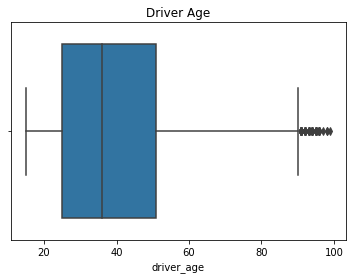

In [132]:
import seaborn as sns
_ = sns.boxplot(x=data_cut['driver_age'])
_ = plt.title('Driver Age')

In [25]:
# outlier compensation?
q1 = data_cut['driver_age'].quantile(0.25)
q3 = data_cut['driver_age'].quantile(0.75)
IQR = q3 - q1
filter = (data_cut['driver_age'] >= q1 - 1.5 * IQR) & (data_clean['driver_age'] <= q3 + 1.5 *IQR)
data_cut = data_cut.loc[filter]  
data_cut.shape

(270668, 11)

#### Weekday

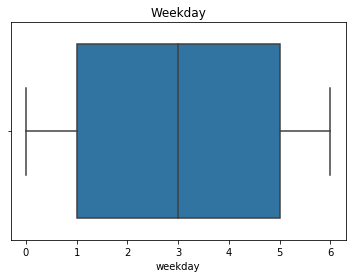

In [133]:
_ = sns.boxplot(x=data_cut['weekday'])
_ = plt.title('Weekday')


#### Violation Raw####

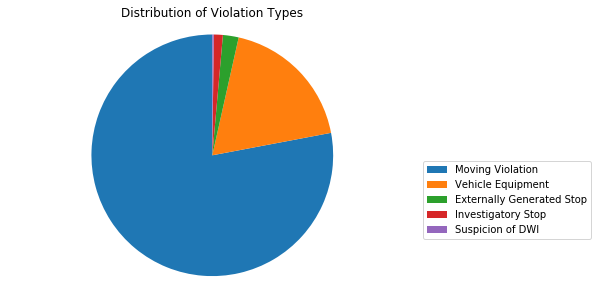

In [166]:
# Pie chart
labels = ['Moving Violation', 'Vehicle Equipment', 'Externally Generated Stop', 
          'Investigatory Stop', 'Suspicion of DWI']
sizes = [77.9, 18.5, 2.1, 1.2, .2]

  
fig1, ax1 = plt.subplots()
ax1.pie(sizes,
        startangle=90, )

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title('Distribution of Violation Types')
plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,0.5))
plt.show()

In [121]:
# take out winooski due to outlier
data_cut = data_cut[data_cut.violation_raw != '(Winooski) Be On Look Rqst']
data_cut = data_cut[data_cut.violation_raw != '(Winooski) Mtr Vhc Vltn']
data_cut['violation_raw'].value_counts()

Moving Violation             210896
Vehicle Equipment             50053
Externally Generated Stop      5789
Investigatory Stop             3432
Suspicion of DWI                578
Name: violation_raw, dtype: int64

#### Stop Time

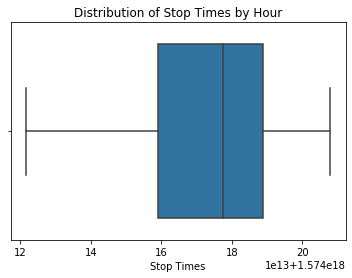

In [168]:
data_cut['stop_time_int'] = data_cut.stop_time.astype(np.int64)

_ = sns.boxplot(data_cut['stop_time_int'])
_ = plt.title('Distribution of Stop Times by Hour')
_ = plt.xlabel('Stop Times')

#### Police Department

In [47]:
data_cut['police_department'].value_counts(normalize=True)

MIDDLESEX VSP                     0.099786
ROYALTON VSP                      0.093546
WILLISTON VSP                     0.086726
NEW HAVEN VSP                     0.083933
VSP HEADQUARTERS - FIELD FORCE    0.083918
ROCKINGHAM VSP                    0.082559
RUTLAND VSP                       0.080128
ST ALBANS VSP                     0.075450
BRADFORD VSP                      0.075328
SHAFTSBURY VSP                    0.075044
BRATTLEBORO VSP                   0.072295
ST JOHNSBURY VSP                  0.054081
DERBY VSP                         0.036735
VSP HQ- BCI/SIU/NIU               0.000469
Name: police_department, dtype: float64

#### Driver gender

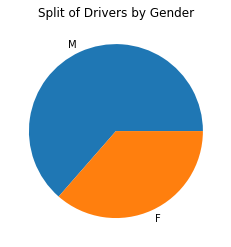

In [174]:
_ = data_cut['driver_gender'].value_counts(normalize=True).plot(kind="pie")
_ = plt.title('Split of Drivers by Gender')
_ = plt.ylabel("")

#### Driver race


---

all white... is this an issue?

In [53]:
data_cut['driver_race'].value_counts(normalize=True)

White       0.956859
Black       0.020202
Asian       0.012669
Hispanic    0.009318
Other       0.000953
Name: driver_race, dtype: float64

#### Search type raw


---

most data comes from no search conducted... should we take this out??

In [57]:
data_cut['search_type_raw'].value_counts(normalize=True)

No Search Conducted               0.991296
Consent Search-Probable Cause     0.005952
Consent Search-Rsnbl Suspicion    0.002398
Search with Warrant               0.000351
(Winooski) Passgr Srch            0.000004
Name: search_type_raw, dtype: float64

In [113]:
# take out winooski due to outlier 
data_cut = data_cut[data_cut.search_type_raw != '(Winooski) Passgr Srch']
data_cut['search_type_raw'].value_counts(normalize=True)

No Search Conducted               0.991302
Consent Search-Probable Cause     0.005950
Consent Search-Rsnbl Suspicion    0.002397
Search with Warrant               0.000351
Name: search_type_raw, dtype: float64

#### Contraband found


---
almost all data is "false"... should we consider taking this out?


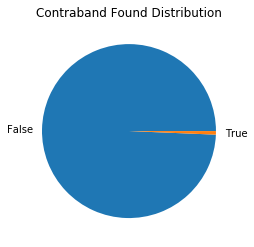

In [176]:
_ = data_cut['contraband_found'].value_counts(normalize=True).plot(kind="pie")
_ = plt.title('Contraband Found Distribution')
_ = plt.ylabel("")

### Stop outcome

In [61]:
data_cut['stop_outcome'].value_counts(normalize=True)

Written Warning    0.616682
Citation           0.383318
Name: stop_outcome, dtype: float64

## **Bivariate Analysis**

#### Driver age vs stop outcome (cont vs. cat -- boxplot)

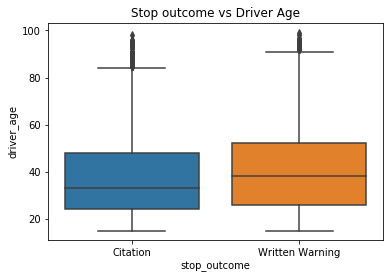

In [177]:
_ = sns.boxplot(x=data_cut['stop_outcome'], y=data_cut['driver_age'])
_ = plt.title('Stop outcome vs Driver Age')

#### Driver gender vs stop outcome (cat vs cat -- stacked col)

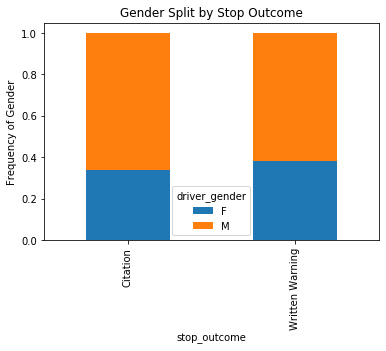

In [181]:
_ = data_cut.groupby('stop_outcome').driver_gender.value_counts(normalize=True)\
.unstack().plot(kind='bar', stacked=True)
_ = plt.title('Gender Split by Stop Outcome')
_ = plt.ylabel('Frequency of Gender')

#### Driver race vs stop outcome (cat vs cat)

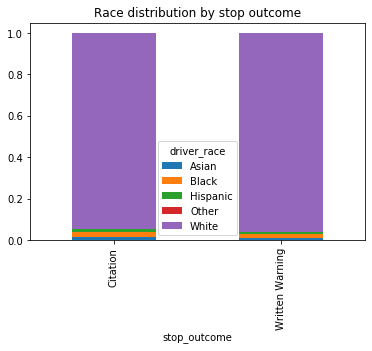

In [184]:
_ = data_cut.groupby('stop_outcome').driver_race.value_counts(normalize=True).unstack()\
.plot(kind='bar', stacked=True)
_ = plt.title('Race distribution by stop outcome')

#### weekday vs stop outcome (cat vs cat)

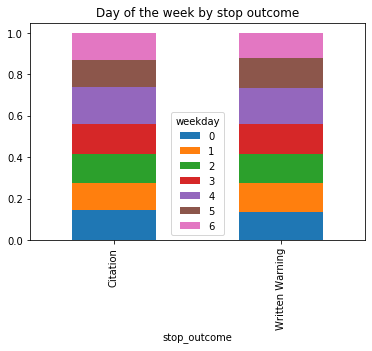

In [183]:
_ = data_cut.groupby('stop_outcome').weekday.value_counts(normalize=True).unstack()\
.plot(kind='bar', stacked=True)
_ = plt.title('Day of the week by stop outcome')

#### Stop time vs stop outcome (cont vs cat)

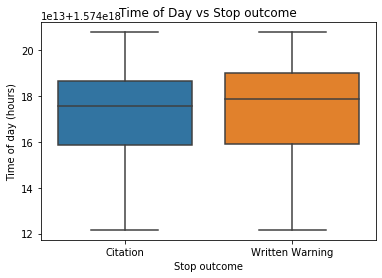

In [185]:
_ = sns.boxplot(x=data_cut['stop_outcome'], y=data_cut['stop_time_int'])
_ = plt.title('Time of Day vs Stop outcome')
_ = plt.ylabel('Time of day (hours)')
_ = plt.xlabel('Stop outcome')

#### Police Department vs stop outcome (cat vs cat)

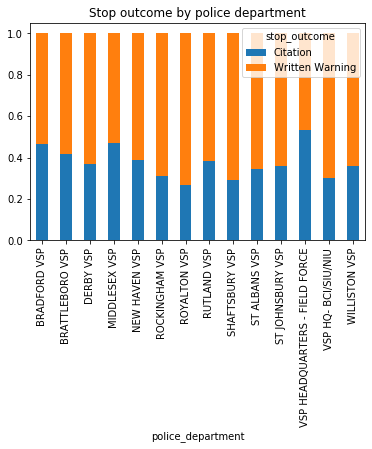

In [98]:
_ = data_cut.groupby('police_department').stop_outcome.value_counts(normalize=True).unstack().plot(kind='bar',stacked=True)
_ = plt.title('Stop outcome by police department')

#### Contraband found vs stop outcome (cat vs cat)

In [186]:
data_cut.groupby('stop_outcome').contraband_found.value_counts().unstack()

contraband_found,False,True
stop_outcome,,
Citation,102490,1281
Written Warning,166477,500


#### Violation raw vs stop outcome

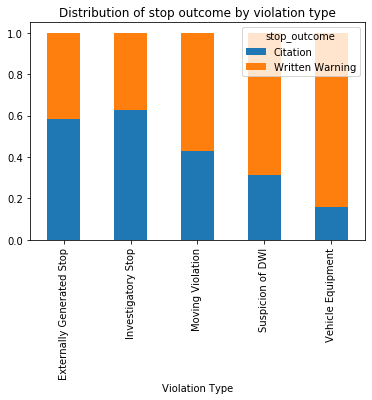

In [187]:
_ = data_cut.groupby('violation_raw').stop_outcome.value_counts(normalize=True).unstack()\
.plot(kind='bar', stacked=True)
_ = plt.title('Distribution of stop outcome by violation type')
_ = plt.xlabel('Violation Type')

#### Search Type raw vs stop outcome

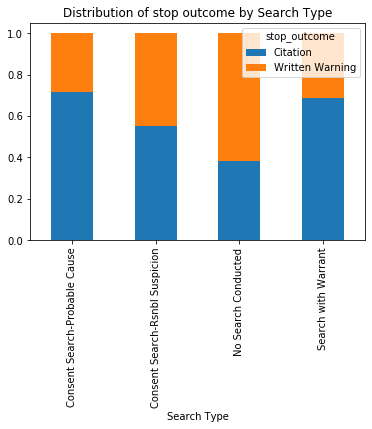

In [188]:
_ = data_cut.groupby('search_type_raw').stop_outcome.value_counts(normalize=True).unstack()\
.plot(kind='bar', stacked=True)
_ = plt.title('Distribution of stop outcome by Search Type')
_ = plt.xlabel('Search Type')

## **Classification Algorithms**